In [ ]:
!wget https://machinehack-be.s3.amazonaws.com/detecting_anomalies_in_wafer_manufacturing_weekend_hackathon_18/Participants_Data_WH18.zip

--2020-09-05 10:10:43--  https://machinehack-be.s3.amazonaws.com/detecting_anomalies_in_wafer_manufacturing_weekend_hackathon_18/Participants_Data_WH18.zip
Resolving machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)... 52.219.66.112
Connecting to machinehack-be.s3.amazonaws.com (machinehack-be.s3.amazonaws.com)|52.219.66.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114903 (112K) [application/zip]
Saving to: ‘Participants_Data_WH18.zip’

Participants_Data_W 100%[===================>] 112.21K   528KB/s    in 0.2s    

2020-09-05 10:10:43 (528 KB/s) - ‘Participants_Data_WH18.zip’ saved [114903/114903]



In [ ]:
!unzip Participants_Data_WH18.zip

Archive:  Participants_Data_WH18.zip
   creating: Participants_Data_WH18/
  inflating: Participants_Data_WH18/Test.csv  
  inflating: __MACOSX/Participants_Data_WH18/._Test.csv  
  inflating: Participants_Data_WH18/Train.csv  
  inflating: __MACOSX/Participants_Data_WH18/._Train.csv  
  inflating: Participants_Data_WH18/Sample_submission.csv  
  inflating: __MACOSX/Participants_Data_WH18/._Sample_submission.csv  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

     |████████████████████████████████| 163kB 3.8MB/s 
  Created wheel for rfpimp: filename=rfpimp-1.3.5-cp36-none-any.whl size=10261 sha256=d479ff97388a100b5e281c2836abe144c47158dcc7e3bb93edd7b088a317d677
  Stored in directory: /root/.cache/pip/wheels/2a/c8/bf/80f91224be00870f84a85aa1782cf6cd62c1289a173b66b8e9
  Created wheel for stratx: filename=stratx-0.4.1-cp36-none-any.whl size=35078 sha256=203fb34620dc74a66e7a4c3a0d76cf89437404e7ea1171d6bb28f7297b9d5762
  Stored in directory: /root/.cache/pip/wheels/ca/c1/e1/3e4c41e3420fe9c706dd4d8ef8d7fb5aba1b6a9547649a2d00
Successfully built rfpimp stratx
     |████████████████████████████████| 66.1MB 53kB/s 


In [ ]:
train = pd.read_csv('Participants_Data_WH18/Train.csv')
test = pd.read_csv('Participants_Data_WH18/Test.csv')

In [ ]:
train.head(5)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head(5)

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1519,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,108.0,179.0,1.6574,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,60.0,120.0,2.0000,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.isnull().sum(),test.isnull().sum(),train.shape,test.shape,train.dtypes

(feature_1       0
 feature_2       0
 feature_3       0
 feature_4       0
 feature_5       0
                ..
 feature_1555    0
 feature_1556    0
 feature_1557    0
 feature_1558    0
 Class           0
 Length: 1559, dtype: int64, feature_1       0
 feature_2       0
 feature_3       0
 feature_4       0
 feature_5       0
                ..
 feature_1554    0
 feature_1555    0
 feature_1556    0
 feature_1557    0
 feature_1558    0
 Length: 1558, dtype: int64, (1763, 1559), (756, 1558), feature_1         int64
 feature_2         int64
 feature_3       float64
 feature_4         int64
 feature_5         int64
                  ...   
 feature_1555      int64
 feature_1556      int64
 feature_1557      int64
 feature_1558      int64
 Class             int64
 Length: 1559, dtype: object)

In [ ]:
df=pd.concat([train,test])

In [ ]:
x=['feature_1','feature_2','feature_3','feature_188','feature_4','feature_1400','feature_352','feature_399','feature_1508','feature_1244','feature_387','feature_1023','feature_21']
df['df_sum'] = df[x].sum(axis=1)
df['df_mean'] = df[x].mean(axis=1)
df['Ag_x']=df['feature_1400']+df['feature_2']
df['Ag_y']=df['feature_1400']+df['feature_352']
df['Ag_z']=df['feature_1400']+df['feature_399']
df['Ag_xx']=df['feature_1400']+df['feature_1508']
df['Ag_yy']=df['feature_1400']+df['feature_3']
df['Ag_zzz']=df['feature_2']+df['feature_399']
df['Ag_xxx']=df['feature_2']+df['feature_352']
df['Ag_yyy']=df['feature_2']+df['feature_3']
df['st_x']=df['feature_1']*df['feature_2']+df['feature_3']

In [ ]:
train = df[df['Class'].isnull()==False]
test = df[df['Class'].isnull()==True]
del test['Class']

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
from math import sqrt 
from sklearn.metrics import roc_auc_score

In [ ]:
X = train_df.drop(labels=['Class'], axis=1)
y = train_df['Class'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.40, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1057, 1569), (1057,), (706, 1569), (706,))

# F1

In [ ]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.07, 
         'num_iterations': 1000,
         'num_leaves': 29,
         'max_depth': -1,
         'min_data_in_leaf': 11,
         'bagging_fraction': 0.80,
         'bagging_freq': 1,
         'bagging_seed': 3,
         'feature_fraction': 0.80,
         'feature_fraction_seed': 2,
         'early_stopping_round': 200,
         'max_bin': 300
         }

lgbm = lgb.train(params=param, verbose_eval=100, train_set=train_data, valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('roc_auc_score:', roc_auc_score(y_cv, y_pred_lgbm))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.224811
[200]	valid_0's rmse: 0.232213
Early stopping, best iteration is:
[35]	valid_0's rmse: 0.216799
roc_auc_score: 0.904021784666946


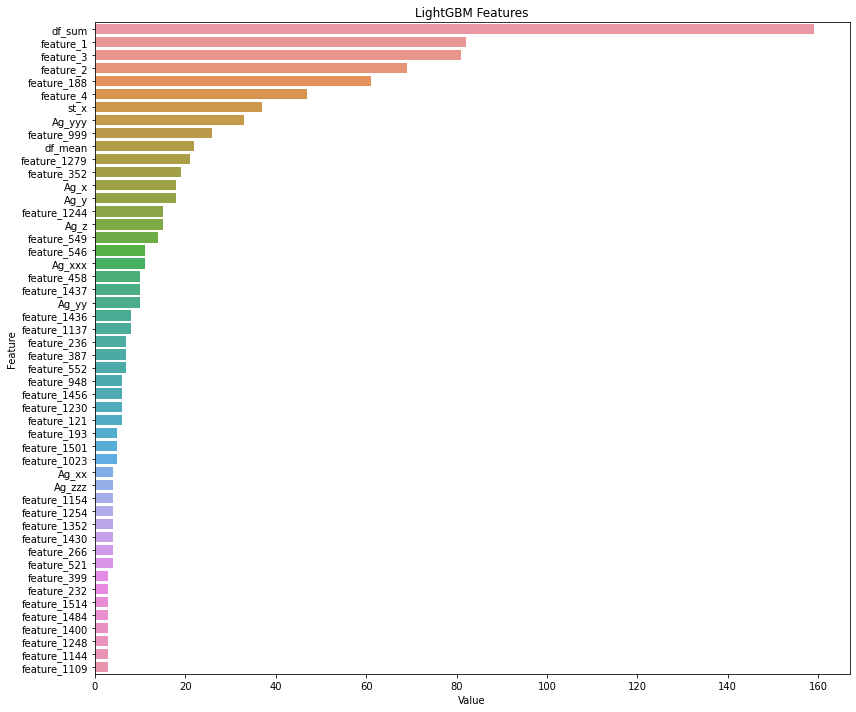

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(12, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=4, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #lgbm = LGBMRegressor(**param)
    lgbm = LGBMRegressor(boosting='gbdt',learning_rate=0.01, n_estimators=1000, random_state=101, subsample=0.8,num_leaves=29)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", roc_auc_score(y_test, y_pred_lgbm))

    errlgb.append(roc_auc_score(y_test, y_pred_lgbm))
    p = lgbm.predict(Xtest)
    y_pred_totlgb.append(p)

RMSLE LGBM:  0.9184120617944147
RMSLE LGBM:  0.9236018196414236
RMSLE LGBM:  0.9091777061701873
RMSLE LGBM:  0.9336304124930989


In [ ]:
np.mean(errlgb,0)

0.9212055000247811

In [ ]:
lgbm_final = np.mean(y_pred_totlgb,0)

In [ ]:
submission = pd.DataFrame({
        "Class":lgbm_final
    })
submission.to_csv('./tr.csv', index=False)
print(submission)

        Class
0    0.437051
1    0.019437
2    0.042944
3    0.372460
4    0.660306
..        ...
751  0.042944
752  0.016508
753  0.003631
754  0.014339
755  0.011028

[756 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('tr.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# F2

In [ ]:
X = train_df.drop(labels=['Class'], axis=1)
y = train_df['Class'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.30, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((1234, 1569), (1234,), (529, 1569), (529,))

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(verbose=1, learning_rate=0.01, n_estimators=550, random_state=101, subsample=0.8)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_cv)
print('roc_auc_score', roc_auc_score(y_cv, y_pred))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0722           0.0007           15.12s
         2           0.0765           0.0004           15.02s
         3           0.0744           0.0006           15.05s
         4           0.0737           0.0005           15.01s
         5           0.0747           0.0005           14.68s
         6           0.0751           0.0006           14.58s
         7           0.0766           0.0004           14.43s
         8           0.0704           0.0005           14.48s
         9           0.0761           0.0004           14.36s
        10           0.0729           0.0006           14.24s
        20           0.0718           0.0002           13.57s
        30           0.0658           0.0002           13.22s
        40           0.0601           0.0002           12.83s
        50           0.0576           0.0002           12.34s
        60           0.0542           0.0001           11.93s
       

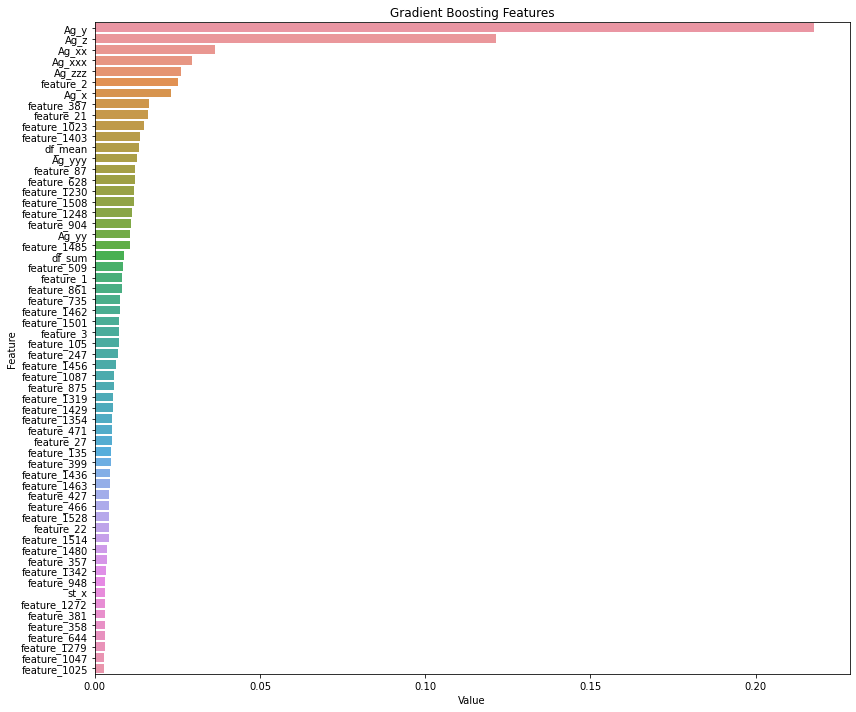

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(gb.feature_importances_, X.columns), reverse=True)[:60], columns=['Value','Feature'])
plt.figure(figsize=(12,10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Gradient Boosting Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold

errgb = []
y_pred_totgb = []

fold = KFold(n_splits=4, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
             
    gb = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, random_state=101, subsample=0.8, max_features='log2')
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)

    print('RMSE', roc_auc_score(y_test, y_pred))

    errgb.append(roc_auc_score(y_test, y_pred))
    p = gb.predict(Xtest)
    y_pred_totgb.append(p)

RMSE 0.9044860368389781
RMSE 0.9334024618678085
RMSE 0.9051497792099296
RMSE 0.9386386939033048


In [ ]:
np.mean(errgb)

0.9204192429550052

In [ ]:
final = np.mean(y_pred_totgb,0)

In [ ]:
submission = pd.DataFrame({
        "Class":final
    })
submission.to_csv('./ensemble.csv', index=False)
print(submission)

        Class
0    0.233190
1    0.036421
2    0.041921
3    0.298441
4    0.492069
..        ...
751  0.030880
752  0.029883
753  0.032121
754  0.029024
755  0.032459

[756 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('ensemble.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# del

In [ ]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='AUC', 
                         depth=2,
                         random_seed=42, 
                         iterations=2000, 
                         learning_rate=0.3,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
cat.fit(X_train, y_train, verbose=50,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)

0:	test: 0.6844886	test1: 0.7059099	best: 0.7059099 (0)	total: 3.67ms	remaining: 7.33s
50:	test: 0.9544960	test1: 0.8348968	best: 0.8503752 (24)	total: 159ms	remaining: 6.09s
100:	test: 0.9714576	test1: 0.8567073	best: 0.8567073 (92)	total: 322ms	remaining: 6.05s
150:	test: 0.9777605	test1: 0.8388837	best: 0.8567073 (92)	total: 480ms	remaining: 5.87s
200:	test: 0.9830516	test1: 0.8470919	best: 0.8567073 (92)	total: 638ms	remaining: 5.71s
250:	test: 0.9856984	test1: 0.8520169	best: 0.8567073 (92)	total: 805ms	remaining: 5.61s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8567073171
bestIteration = 92

Shrink model to first 93 iterations.


In [ ]:
predictions = cat.predict(X_cv)
print('accuracy:', roc_auc_score(y_cv, predictions))

accuracy: 0.6770637898686679


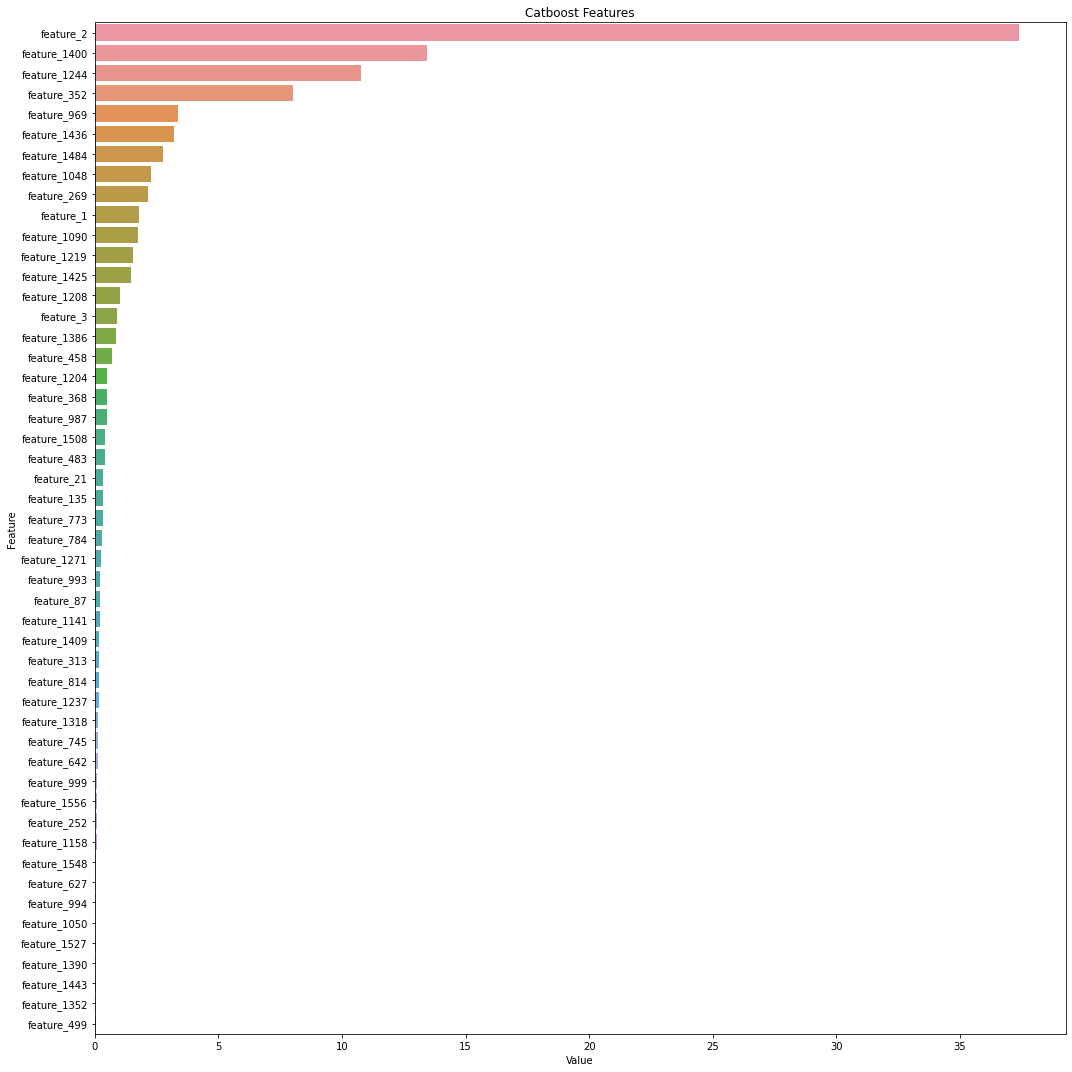

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:

from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='roc_auc_score', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=200)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", roc_auc_score(y_test,y_pred_cat))

    errcat.append(roc_auc_score(y_test,y_pred_cat))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.8870056497175142
Accuracy:  0.9661016949152542
Accuracy:  0.903954802259887
Accuracy:  0.9090909090909091
Accuracy:  0.9431818181818182
Accuracy:  0.9261363636363636
Accuracy:  0.9488636363636364
Accuracy:  0.9034090909090909
Accuracy:  0.9659090909090909
Accuracy:  0.9375


In [ ]:
np.mean(errcat,0)

0.9291153055983565

In [ ]:

cat_final = np.mean(y_pred_totcat,0).round().astype(int)


In [ ]:
yyy = pd.DataFrame(data=cat_final, columns=['Class'])

In [ ]:
submission = pd.DataFrame({
        "Class": yyy['Class']
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

     Class
0        0
1        0
2        0
3        0
4        0
..     ...
751      0
752      0
753      0
754      0
755      0

[756 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
df_train = train_df
df_test = test_df

In [ ]:
X_train = train_df.drop(['Class'],axis=1)
y_train = train_df['Class']

In [ ]:
x=[]
for i in test_df.columns:
  x.append(i)
x=np.array(x)
x

array(['feature_1', 'feature_2', 'feature_3', ..., 'feature_1556',
       'feature_1557', 'feature_1558'], dtype='<U12')

In [ ]:
feats=x

In [ ]:
splits = 15
folds =StratifiedKFold(n_splits=splits, random_state=42,shuffle=True)
oof_preds = np.zeros((len(df_test), 2))
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = X_train.columns
final_preds = []
random_state = [22,44,66,77,88,99,101]
counter = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,y_train)):
        print("iter_ {}".format(fold_))
        X_trn,y_trn = X_train[feats].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[feats].iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(boosting='gbdt',learning_rate=0.1, n_estimators=1000, random_state=101, subsample=0.9,max_depth=-1,num_leaves=31)#
         #,
         #min_data_in_leaf=11,
         #bagging_fraction=0.90,
         #bagging_freq=2,
         #bagging_seed=3,
         #feature_fraction=0.90,
         #feature_fraction_seed=2,
         #early_stopping_round=200,
         #max_bin=1000)#(n_estimators=1000,max_depth=4,random_state=42)#dart
        clf.fit(X_trn, y_trn,eval_set=[(X_trn, y_trn), (X_val, y_val)],verbose=0,
                eval_metric='multi_error',early_stopping_rounds=100)
        
        imp = importances(clf,X_val,y_val)
        imp.rename(columns={'Importance':f'Importance_{fold_}'},inplace=True)
        feature_importance_df = pd.merge(feature_importance_df,imp,on='Feature')
        final_preds.append(roc_auc_score(y_pred=clf.predict(X_val),y_true=y_val))
        
        oof_preds += clf.predict_proba(df_test[feats])
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

iter_ 0
iter_ 1
iter_ 2
iter_ 3
iter_ 4
iter_ 5
iter_ 6
iter_ 7
iter_ 8
iter_ 9
iter_ 10
iter_ 11
iter_ 12
iter_ 13
iter_ 14
0.924583514414023


In [ ]:
preds_x = [np.argmax(x) for x in oof_preds]

In [ ]:
submission = pd.DataFrame({
        "Class":preds_x
    })
submission.to_csv('./bt.csv', index=False)
print(submission)

     Class
0        0
1        0
2        0
3        0
4        0
..     ...
751      0
752      0
753      0
754      0
755      0

[756 rows x 1 columns]


In [ ]:
from google.colab import files
files.download('bt.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>